In [1]:
import cv2
import pydicom
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [4]:
# Load the data
path = "../../data-sample/train/"
image_paths = [os.path.join(path, f) for f in os.listdir(path)] 

In [5]:
# check resolution of the images
image_shapes = []
for image_path in image_paths:
    image = pydicom.dcmread(image_path)
    image_shapes.append(image.pixel_array.shape)
image_shapes

C:\Users\Amar\Git\xraydetection\venv\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


[(3072, 2540),
 (3072, 3072),
 (2754, 2332),
 (2880, 2304),
 (3072, 3072),
 (2430, 1994)]

In [6]:
# check max pixel values and bits stored of the images
max_pixel_values = []
bits_stored = []
for image_path in image_paths:
    image = pydicom.dcmread(image_path)
    max_pixel_values.append(image.pixel_array.max())
    bits_stored.append(image.BitsStored)
max_pixel_values, bits_stored

([16383, 16383, 16383, 4095, 16383, 4032], [14, 14, 14, 12, 14, 12])

In [16]:
# load the first image
image = pydicom.dcmread(image_paths[0])
image

C:\Users\Amar\Git\xraydetection\venv\lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '1c32170b4af4ce1a3030eb8167753b06'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 154
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1c32170b4af4ce1a3030eb8167753b06
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '119Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0008) Number of Frames                    IS: '1'
(0028, 0010) Rows                                US: 3072
(0028, 0011) Columns                   

In [17]:
image.pixel_array.dtype

dtype('uint16')

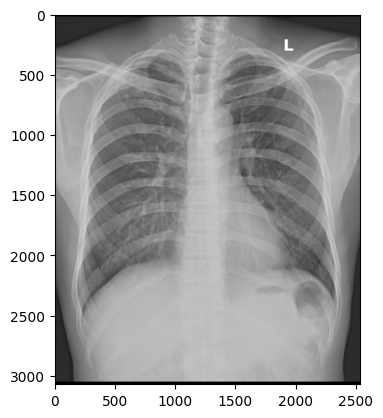

In [18]:
# plot the image
plt.imshow(image.pixel_array, cmap="gray")

In [19]:
image.pixel_array.max()

16383

In [20]:
# rescale the image based on the bits stored to normal pixel range of 0-255
image_rescaled = np.rint((image.pixel_array / 2**image.BitsStored) * 255)
image_rescaled = image_rescaled.astype("uint8")
image_rescaled.max(), image_rescaled.min()

(255, 0)

In [21]:
# resize the image so that the longer side is 640

# check which side is longer
height, width = image_rescaled.shape

if height > width:
    # height must be 640, width will be scaled accordingly
    new_height = 640
    new_width = int(width * (new_height / height))
elif width > height:
    # other way around
    new_width = 640
    new_height = int(height * (new_width / width))
else:
    # square image, resize to 640x640
    new_height = 640
    new_width = 640
image_reshaped = cv2.resize(image_rescaled, (new_width, new_height))

In [22]:
image_rescaled.shape, image_reshaped.shape

((3072, 2540), (640, 529))

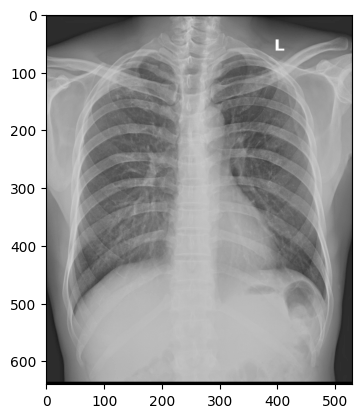

In [23]:
# plot the resized image
plt.imshow(image_reshaped, cmap="gray")

In [24]:
# convert grayscale image to rgb (triple the channels)
image_rgb = cv2.cvtColor(image_reshaped, cv2.COLOR_GRAY2RGB)

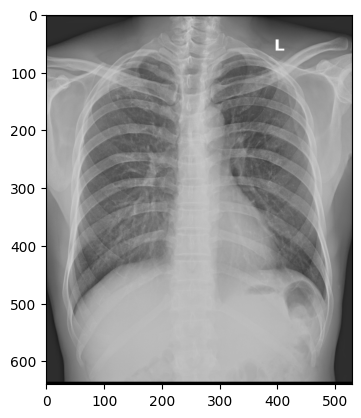

In [25]:
# plot the rgb image
plt.imshow(image_rgb)

In [26]:
# save the image as png
cv2.imwrite("image.png", image_rgb)

True

### Preparing the Annotations
- The annotations are stored in a csv file containing class_name, class_id and BBox coordinates of opposing corners.
- We need to convert these annotations to the format required by yolov5
- The format required by yolov5 is a txt file for each image containing the class_id and normalized BBox coordinates with one line per annotation. If the image does not have any annotations, no txt file should be produced.
- The normalized BBox coordinates are in the format: x_center, y_center, width, height

Outline of the pipeline:
- Load the csv file
- Drop all rows with "No finding" class_name
- Group the data by image_id
- Iterate through the grouped dataframe
- Load the dicom image and get the shape
- Compute the BBox coordinates in Yolo format
- Normalize the coordinates
- Save the annotations in a txt file with the same name as the image_id
- Repeat for all images

In [30]:
# load the csv file
data = pd.read_csv("../../data-sample/train.csv")
data

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [33]:
# list all unique class_names and their corresponding class_ids
class_names = data["class_name"].unique()
class_ids = data["class_id"].unique()

for class_name, class_id in zip(class_names, class_ids):
    print(class_name, class_id)

No finding 14
Cardiomegaly 3
Aortic enlargement 0
Pleural thickening 11
ILD 5
Nodule/Mass 8
Pulmonary fibrosis 13
Lung Opacity 7
Atelectasis 1
Other lesion 9
Infiltration 6
Pleural effusion 10
Calcification 2
Consolidation 4
Pneumothorax 12


In [34]:
# drop all "No finding" rows since no txt file should be produced
annotations = data[data["class_name"] != "No finding"]
annotations

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
...,...,...,...,...,...,...,...,...
67903,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0
67906,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0
67907,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0
67908,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0


In [35]:
# group the data by image id
grouped_data = annotations.groupby("image_id")

In [37]:
# we will need to adjust the coordinates to fit with the resized image
# for this we need the shape of the original image. As such, we need to iterate through the dicom images

dicom_root = "../../data-sample/train/"
dicom_paths = [os.path.join(dicom_root, f) for f in os.listdir(dicom_root)]

In [51]:
# since we only have a data sample, we will iterate the dicom files list instead of the grouped dat

dicom_path = dicom_paths[0]

# get the image shape from the dicom
image = pydicom.dcmread(dicom_path)
image_shape = image.pixel_array.shape

# get the image id
image_id = dicom_path.split("/")[-1].split(".")[0]

# get the annotations for the image_id
group = grouped_data.get_group(image_id)

# extract the data
class_id = group["class_id"]
x_min = group["x_min"]
y_min = group["y_min"]
x_max = group["x_max"]
y_max = group["y_max"]

# compute the yolo coordinates
x_center = (x_min + x_max) / 2
y_center = (y_min + y_max) / 2
width = x_max - x_min
height = y_max - y_min

# normalize the coordinates to the image dimensions
x_center = x_center / image_shape[1]
y_center = y_center / image_shape[0]
width = width / image_shape[1]
height = height / image_shape[0]

In [40]:
class_id, x_center, y_center, width, height

(5        11
 2679     13
 5688     11
 15853    13
 21726    13
 47599    13
 55111    11
 61767    13
 65294    13
 Name: class_id, dtype: int64,
 5        0.309843
 2679     0.287598
 5688     0.753346
 15853    0.741142
 21726    0.708661
 47599    0.287205
 55111    0.767913
 61767    0.255906
 65294    0.712795
 dtype: float64,
 5        0.128581
 2679     0.206706
 5688     0.158366
 15853    0.272461
 21726    0.193522
 47599    0.204590
 55111    0.162598
 61767    0.192220
 65294    0.210286
 dtype: float64,
 5        0.125984
 2679     0.172835
 5688     0.105118
 15853    0.070472
 21726    0.091339
 47599    0.142126
 55111    0.074409
 61767    0.095276
 65294    0.060236
 dtype: float64,
 5        0.024740
 2679     0.082682
 5688     0.081706
 15853    0.052083
 21726    0.094076
 47599    0.112305
 55111    0.056966
 61767    0.097982
 65294    0.065755
 dtype: float64)

In [41]:
# convert the annotations to a single pd dataframe
annotations = pd.DataFrame({
    "class_id": class_id,
    "x_center": x_center,
    "y_center": y_center,
    "width": width,
    "height": height
})
annotations

,class_id,x_center,y_center,width,height
5,11,0.309843,0.128581,0.125984,0.024740
2679,13,0.287598,0.206706,0.172835,0.082682
5688,11,0.753346,0.158366,0.105118,0.081706
15853,13,0.741142,0.272461,0.070472,0.052083
21726,13,0.708661,0.193522,0.091339,0.094076
47599,13,0.287205,0.204590,0.142126,0.112305
55111,11,0.767913,0.162598,0.074409,0.056966
61767,13,0.255906,0.192220,0.095276,0.097982
65294,13,0.712795,0.210286,0.060236,0.065755


In [42]:
annotations.to_csv("annotations.csv", sep=" ", index=False, header=False)

In [43]:
# get the file name
file_name = os.path.join("./", f"{image_id}.txt")

# save the annotations to a txt file
annotations.to_csv(file_name, sep=" ", index=False, header=False)

627.0 357.0 947.0 433.0
511.0 508.0 950.0 762.0
1780.0 361.0 2047.0 612.0
1793.0 757.0 1972.0 917.0
1684.0 450.0 1916.0 739.0
549.0 456.0 910.0 801.0
1856.0 412.0 2045.0 587.0
529.0 440.0 771.0 741.0
1734.0 545.0 1887.0 747.0


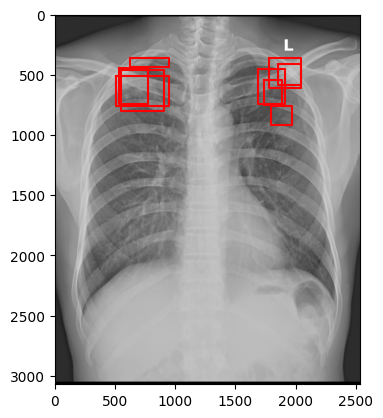

In [54]:
# let's show the image with its annotations
plt.imshow(image.pixel_array, cmap="gray")
image_width = image.pixel_array.shape[1]
image_height = image.pixel_array.shape[0]

# let's draw the annotations
for i in range(len(group)):
    x_min = group["x_min"].iloc[i]
    y_min = group["y_min"].iloc[i]
    x_max = group["x_max"].iloc[i]
    y_max = group["y_max"].iloc[i]
    print(x_min, y_min, x_max, y_max)
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color="red")

In [13]:
image_shape

(3072, 2540)

787.0000000000001 395.0 320.0 76.0
627.0000000000001 357.0 947.0000000000001 433.0
730.5 635.0 438.99999999999994 254.0
511.0 508.0 950.0 762.0
1913.4999999999998 486.5 267.0 251.0
1779.9999999999998 361.0 2046.9999999999998 612.0
1882.5 837.0 179.0 160.0
1793.0 757.0 1972.0 917.0
1800.0 594.5 232.0 289.0
1684.0 450.0 1916.0 739.0
729.5 628.5 361.0 345.0
549.0 456.0 910.0 801.0
1950.4999999999998 499.5 189.0 175.0
1855.9999999999998 412.0 2044.9999999999998 587.0
650.0 590.5 242.00000000000003 301.0
529.0 440.0 771.0 741.0
1810.5 646.0 153.0 202.0
1734.0 545.0 1887.0 747.0


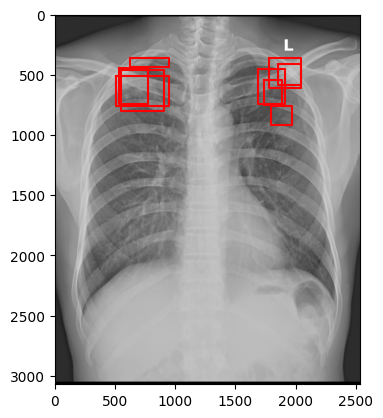

In [53]:
# let's draw the annotations again, this time with the normalized coordinates
plt.imshow(image.pixel_array, cmap="gray")

# let's draw the annotations
for i in range(len(group)):
    x_cen = x_center.iloc[i] * image_shape[1]
    y_cen = y_center.iloc[i] * image_shape[0]
    w = width.iloc[i] * image_shape[1]
    h = height.iloc[i] * image_shape[0]
    
    x_min = x_cen - w / 2
    y_min = y_cen - h / 2
    x_max = x_cen + w / 2
    y_max = y_cen + h / 2
    
    print(x_cen, y_cen, w, h)
    print(x_min, y_min, x_max, y_max)
    
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color="red")

### Creating a dataset split

In [34]:
# we will split the data into train, validation and test set
# we will use a 70-15-15 split

# get the unique image ids
image_ids = data["image_id"].unique()

# shuffle the image ids
np.random.shuffle(image_ids)

# get the number of images
n_images = len(image_ids)

# get the number of images for each split
n_train = int(0.7 * n_images)
n_val = int(0.15 * n_images)
n_test = n_images - n_train - n_val

# split the image ids
train_ids = image_ids[:n_train]
val_ids = image_ids[n_train:n_train+n_val]
test_ids = image_ids[n_train+n_val:]

In [35]:
# let's check the label distributions before and after the split

# before
data["class_name"].value_counts()

class_name
No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: count, dtype: int64

In [36]:
# after
train_data = data[data["image_id"].isin(train_ids)]
train_data["class_name"].value_counts()

class_name
No finding            22218
Aortic enlargement     5075
Cardiomegaly           3789
Pleural thickening     3431
Pulmonary fibrosis     3341
Nodule/Mass            1805
Lung Opacity           1752
Pleural effusion       1716
Other lesion           1544
Infiltration            891
ILD                     689
Calcification           632
Consolidation           389
Atelectasis             186
Pneumothorax            141
Name: count, dtype: int64

In [37]:
val_data = data[data["image_id"].isin(val_ids)]
val_data["class_name"].value_counts()

class_name
No finding            4773
Aortic enlargement    1027
Cardiomegaly           817
Pleural thickening     711
Pulmonary fibrosis     695
Pleural effusion       384
Nodule/Mass            383
Other lesion           361
Lung Opacity           353
Calcification          195
Infiltration           179
ILD                    163
Consolidation           87
Atelectasis             48
Pneumothorax            39
Name: count, dtype: int64

In [38]:
test_data = data[data["image_id"].isin(test_ids)]
test_data["class_name"].value_counts()

class_name
No finding            4827
Aortic enlargement    1060
Cardiomegaly           821
Pleural thickening     700
Pulmonary fibrosis     619
Nodule/Mass            392
Lung Opacity           378
Pleural effusion       376
Other lesion           298
Infiltration           177
ILD                    148
Calcification          133
Consolidation           80
Pneumothorax            46
Atelectasis             45
Name: count, dtype: int64